In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import xml.dom.minidom
import os.path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from sklearn.model_selection import train_test_split
from scipy.misc import imresize 
import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import linear_model, decomposition
import itertools 
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
import random
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.initializers import RandomNormal  
from keras.layers.normalization import BatchNormalization
from copy import deepcopy
#plt.switch_backend('agg')
%matplotlib inline
#############################################################
# region of segmentation
def img_dim(obj):
    x_max = int(math.ceil(float(obj.find('bndbox').find('xmax').text)))
    y_max = int(math.ceil(float(obj.find('bndbox').find('ymax').text)))
    x_min = int(math.ceil(float(obj.find('bndbox').find('xmin').text)))
    y_min = int(math.ceil(float(obj.find('bndbox').find('ymin').text)))
    return [x_max,y_max,x_min,y_min]


            
# convert name to label
def name2label(name):
    name_list = ['dog',
 'sheep',
 'person',
 'pottedplant',
 'boat',
 'bird',
 'horse',
 'bus',
 'tvmonitor',
 'sofa',
 'diningtable',
 'car',
 'motorbike',
 'train',
 'bicycle',
 'cat',
 'chair',
 'cow',
 'bottle',
 'aeroplane']
    
    return name_list.index(name)


# save data
def all_image_data_label(file, siz):
    image_buffer  =  []
    label_buffer = []
    for i in range(len(file)):
        tree = ET.parse('/home/cc/notebook/VOCdevkit/VOC2012/Annotations/'+file[i])
        root = tree.getroot()
        img_path = '/home/cc/notebook/VOCdevkit/VOC2012/JPEGImages/'+root.find('filename').text
        img = mpimg.imread(img_path)
        image_buffer.append(imresize(img, siz)/255) # resize and 0 to 1
        obj = root.findall('object')
        label_img = [0]*20
        for j in range(len(obj)):
            name = obj[j].find('name').text
            label_img[name2label(name)] = 1
    
        label_buffer.append(label_img)
    
    return image_buffer,label_buffer 

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def modelAnalysis(test_y, predict,target_na,cna):        
    print(classification_report(test_y, predict, target_names=target_na))
    print('accuracy', accuracy_score(test_y, predict))
    mat = confusion_matrix(test_y, predict)
    
    target_na = np.array(target_na)
    plt.figure(figsize=(10,10))
    a = plot_confusion_matrix(mat, classes = target_na, normalize = False)
    plt.grid(b=False)
    plt.savefig(cna)
    plt.show()
    

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    temp = []
    mat = cm
    for i in range(len(mat)):
        temp.append((mat[i, :].astype(np.float64)/(sum(mat[i])+1e-32).tolist()))
    
    mat = np.array(temp)
    
    plt.imshow(mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        thresh = sum(cm[i])/ 2.
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

def first_k(output,kn):
    for i in range(kn):
        output[np.arange(len(output)),np.argmax(output,axis = 1)] = -1

    output[np.where(output>0)] = 0
    output[np.where(output<-0.5)] = 1
    return output.astype(np.int)

def convert_label(y_train,predict_score,kn):
    predict_y = first_k(predict_score,kn)
    tmp = y_train&predict_y
    label = []
    pred = []
    for i in range(len(tmp)):
        if np.where(tmp[i]==1)[0].shape[0]<0.1: # no label match  
            label.append(random.choice(np.where(y_train[i]>0.7)[0])) # train label
            pred.append(np.argmax(predict_score[i]))
        else:
            tmp_label = random.choice(np.where(tmp[i]>0.7)[0])
            pred.append(tmp_label)
            label.append(tmp_label)
            
    return label, pred



#######################################################################
file = os.listdir('VOCdevkit/VOC2012/Annotations')
img_size = 64
kn = 1

name_list = ['dog',
 'sheep',
 'person',
 'pottedplant',
 'boat',
 'bird',
 'horse',
 'bus',
 'tvmonitor',
 'sofa',
 'diningtable',
 'car',
 'motorbike',
 'train',
 'bicycle',
 'cat',
 'chair',
 'cow',
 'bottle',
 'aeroplane']


###########################################################################
file = os.listdir('VOCdevkit/VOC2012/Annotations')
dummy_label = np.random.randint(0,10,len(file))

#train_file, test_file, dummy_train_y, dummy_test_y = train_test_split(file, dummy_label, test_size=0.3, random_state=99999)

Using TensorFlow backend.


pd.DataFrame(train_file).to_csv('train_index.csv',index=False)
pd.DataFrame(test_file).to_csv('test_index.csv',index=False)

In [2]:
train_file = pd.read_csv('train_index.csv').values[:,0].tolist()
test_file = pd.read_csv('test_index_all.csv').values[:,0].tolist()
val_file = pd.read_csv('val_nn_index.csv').values[:,0].tolist()

In [3]:
img, label = all_image_data_label(train_file, (img_size,img_size)) # resize 128 to 128
test_img, test_label = all_image_data_label(test_file, (img_size,img_size)) # resize 128 to 128
val_img, val_label = all_image_data_label(val_file, (img_size,img_size)) # resize 128 to 128

x_train = np.array(img)
y_train = label
x_test = np.array(test_img)
y_test = test_label
x_val = np.array(val_img)
y_val = val_label
#y_train = keras.utils.to_categorical(y_train, len(name_list))
#y_test = keras.utils.to_categorical(y_test, len(name_list))
y_train = np.array(y_train).astype(np.int)
y_test = np.array(y_test).astype(np.int)
y_val = np.array(y_val).astype(np.int)

In [4]:
x_train.shape[1:]

(64, 64, 3)

# Load CNN from trained result of Titan X and further training

In [5]:
batch_size = 64
num_classes = 20
epochs = 1
data_augmentation = True
num_predictions = 20
batch_size    = 128
epochs        = 1

model = Sequential()

model.add(Conv2D(124, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.0002), kernel_initializer=RandomNormal(stddev = 0.01),input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(96, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.0002), kernel_initializer=RandomNormal(stddev = 0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.0002), kernel_initializer=RandomNormal(stddev = 0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding = 'same'))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.0002), kernel_initializer=RandomNormal(stddev = 0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.0002), kernel_initializer=RandomNormal(stddev = 0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding = 'same'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

model.load_weights('final_weight.h5')

predict_score111 = model.predict(x_train)
predict_score112 = model.predict(x_test)
predict_score113 = model.predict(x_val)

# Training, validaton performance and choosing parameter

training-top1
             precision    recall  f1-score   support

        dog       0.44      0.30      0.36       666
      sheep       0.37      0.53      0.44       206
     person       0.87      0.84      0.85      6076
pottedplant       0.58      0.21      0.31       142
       boat       0.59      0.53      0.56       298
       bird       0.33      0.54      0.41       542
      horse       0.49      0.13      0.21       190
        bus       0.91      0.60      0.72       230
  tvmonitor       0.45      0.66      0.54       224
       sofa       0.45      0.17      0.24       139
diningtable       0.67      0.03      0.06        60
        car       0.64      0.44      0.52       474
  motorbike       0.90      0.34      0.49       211
      train       0.67      0.70      0.68       354
    bicycle       0.51      0.39      0.44       192
        cat       0.40      0.79      0.53       719
      chair       0.45      0.74      0.56       484
        cow       0.45      0.1

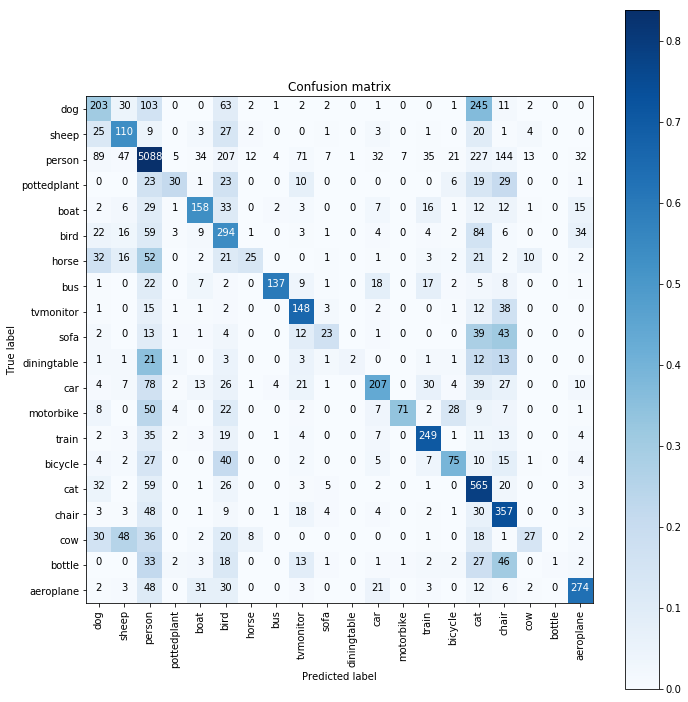

validation-top1
             precision    recall  f1-score   support

        dog       0.45      0.30      0.36       125
      sheep       0.43      0.49      0.46        45
     person       0.86      0.79      0.82      1061
pottedplant       0.29      0.08      0.12        26
       boat       0.53      0.45      0.49        38
       bird       0.27      0.49      0.35        87
      horse       0.44      0.14      0.22        28
        bus       1.00      0.56      0.72        32
  tvmonitor       0.27      0.42      0.33        40
       sofa       0.27      0.11      0.15        28
diningtable       0.00      0.00      0.00        10
        car       0.57      0.35      0.44        82
  motorbike       0.79      0.39      0.52        28
      train       0.74      0.75      0.74        64
    bicycle       0.46      0.41      0.43        32
        cat       0.30      0.79      0.43        98
      chair       0.28      0.59      0.38        70
        cow       0.59      0

/home/cc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


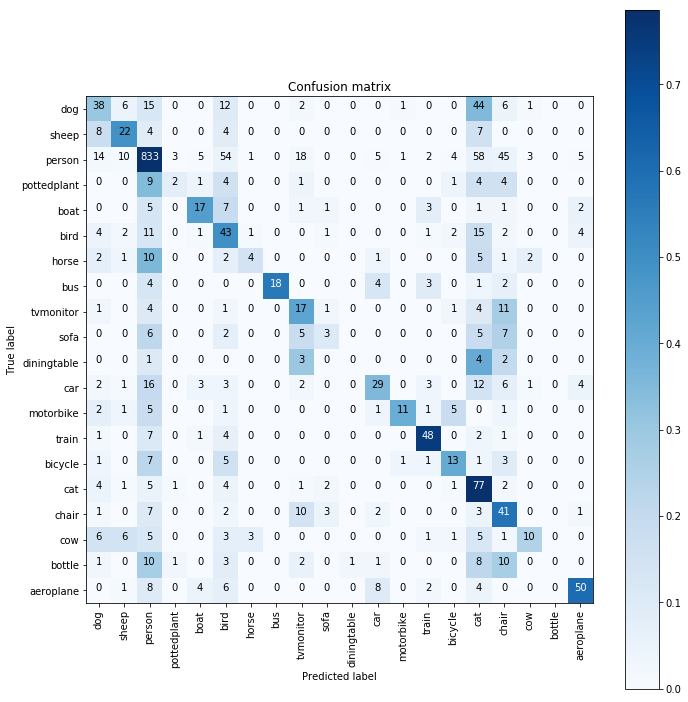

training-top2
             precision    recall  f1-score   support

        dog       0.46      0.81      0.59       715
      sheep       0.43      0.68      0.52       210
     person       0.92      0.87      0.89      5729
pottedplant       0.43      0.44      0.44       135
       boat       0.63      0.66      0.64       286
       bird       0.55      0.76      0.64       543
      horse       0.94      0.48      0.64       248
        bus       0.92      0.74      0.82       215
  tvmonitor       0.49      0.88      0.63       239
       sofa       0.50      0.61      0.55       161
diningtable       0.67      0.72      0.69       117
        car       0.80      0.69      0.74       541
  motorbike       0.95      0.50      0.65       223
      train       0.91      0.76      0.83       349
    bicycle       0.95      0.65      0.77       217
        cat       0.82      0.87      0.85       718
      chair       0.99      0.91      0.95       541
        cow       1.00      0.4

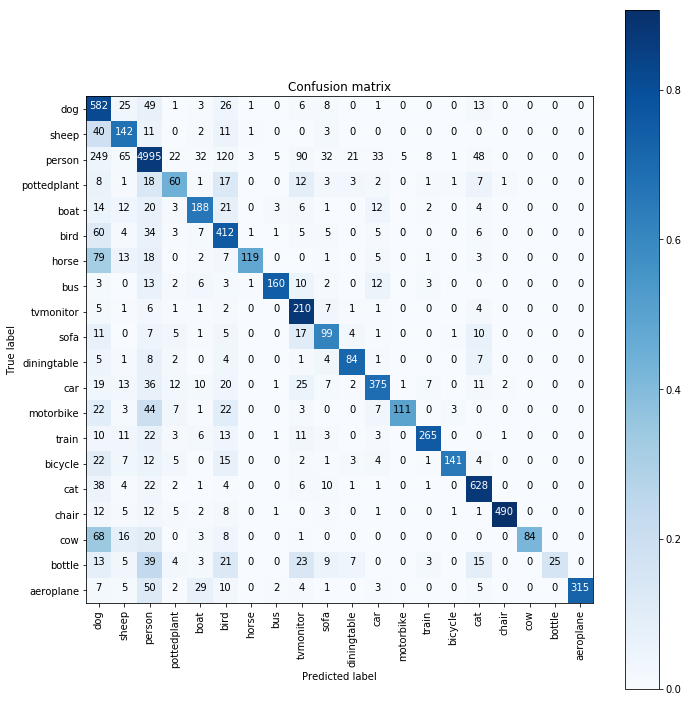

validation-top2
             precision    recall  f1-score   support

        dog       0.44      0.76      0.56       142
      sheep       0.44      0.64      0.52        44
     person       0.90      0.83      0.87      1008
pottedplant       0.24      0.24      0.24        21
       boat       0.51      0.59      0.55        37
       bird       0.42      0.70      0.53        87
      horse       0.88      0.54      0.67        41
        bus       0.91      0.70      0.79        30
  tvmonitor       0.30      0.61      0.40        38
       sofa       0.26      0.30      0.28        30
diningtable       0.37      0.67      0.48        15
        car       0.88      0.61      0.72        87
  motorbike       1.00      0.50      0.67        32
      train       0.87      0.81      0.84        59
    bicycle       1.00      0.66      0.79        38
        cat       0.77      0.86      0.81        95
      chair       0.97      0.84      0.90        93
        cow       1.00      0

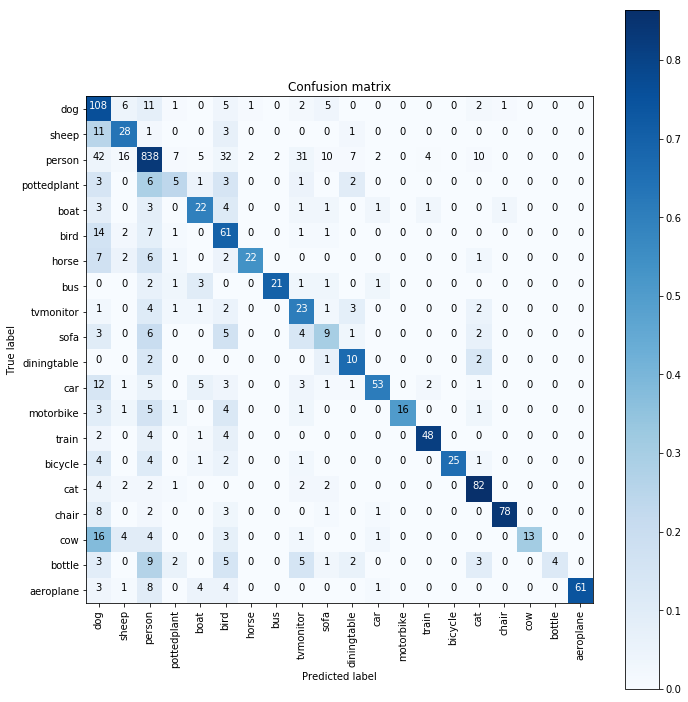

In [6]:
thres = np.zeros(20)
thres[2] = 1*0.3
print('training-top1')
predict_score = deepcopy(predict_score111-thres)
y_train2,predict_y2 = convert_label(y_train,predict_score,1)
modelAnalysis(y_train2, predict_y2,name_list,'cnn1.png')
print('validation-top1')
predict_score = deepcopy(predict_score113-thres)
y_val2,predict_y2 = convert_label(y_val,predict_score,1)
modelAnalysis(y_val2, predict_y2,name_list,'cnn12.png')

print('training-top2')
predict_score = deepcopy(predict_score111-thres)
y_train2,predict_y2 = convert_label(y_train,predict_score,2)
modelAnalysis(y_train2, predict_y2,name_list,'cnn3.png')
print('validation-top2')
predict_score = deepcopy(predict_score113-thres)
y_val2,predict_y2 = convert_label(y_val,predict_score,2)
modelAnalysis(y_val2, predict_y2,name_list,'cnn22.png')


# Testing result

testing-top1
             precision    recall  f1-score   support

        dog       0.34      0.22      0.27       194
      sheep       0.35      0.37      0.36        62
     person       0.83      0.81      0.82      1546
pottedplant       0.36      0.08      0.13        49
       boat       0.63      0.57      0.60        82
       bird       0.23      0.46      0.31       131
      horse       0.54      0.14      0.23        49
        bus       0.90      0.47      0.62        57
  tvmonitor       0.32      0.57      0.41        44
       sofa       0.46      0.19      0.27        31
diningtable       0.67      0.09      0.16        22
        car       0.55      0.36      0.43       115
  motorbike       0.83      0.22      0.35        45
      train       0.64      0.69      0.66        86
    bicycle       0.40      0.33      0.36        42
        cat       0.35      0.70      0.46       199
      chair       0.42      0.56      0.48       127
        cow       0.33      0.11

/home/cc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


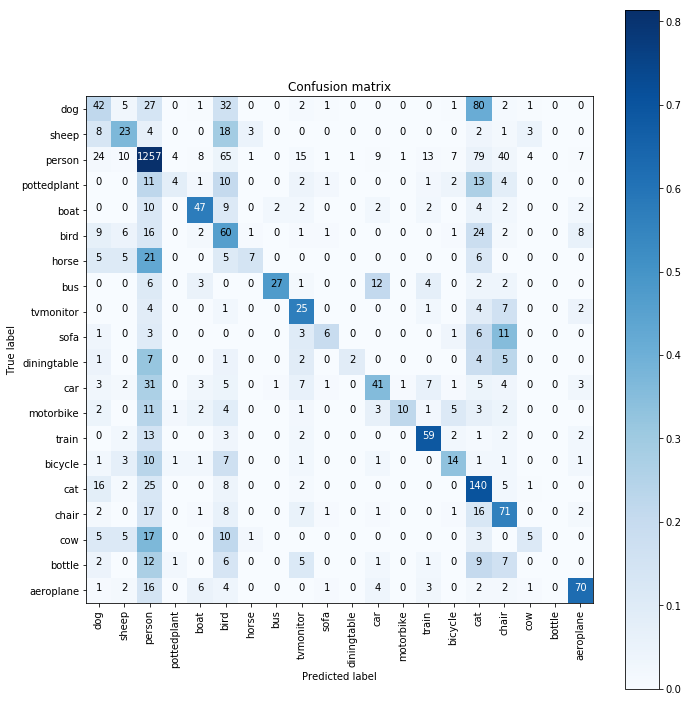

testing-top2
             precision    recall  f1-score   support

        dog       0.45      0.78      0.57       216
      sheep       0.42      0.67      0.51        57
     person       0.88      0.84      0.86      1471
pottedplant       0.28      0.24      0.26        46
       boat       0.59      0.70      0.64        80
       bird       0.48      0.71      0.58       129
      horse       0.77      0.38      0.51        63
        bus       0.85      0.62      0.72        55
  tvmonitor       0.38      0.87      0.53        47
       sofa       0.49      0.63      0.55        30
diningtable       0.56      0.56      0.56        34
        car       0.70      0.58      0.64       118
  motorbike       0.94      0.40      0.56        43
      train       0.89      0.77      0.82        81
    bicycle       0.95      0.66      0.78        56
        cat       0.83      0.81      0.82       204
      chair       0.99      0.80      0.89       145
        cow       0.90      0.19

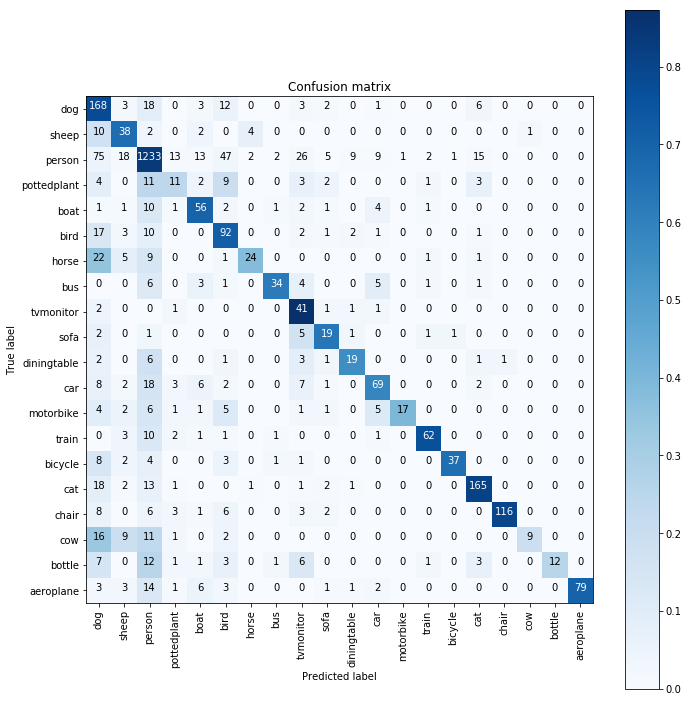

In [7]:
print('testing-top1')
predict_score = deepcopy(predict_score112-thres)
y_test2,predict_y2 = convert_label(y_test,predict_score,1)
modelAnalysis(y_test2, predict_y2,name_list,'cnn2.png')
print('testing-top2')
predict_score = deepcopy(predict_score112-thres)
y_test2,predict_y2 = convert_label(y_test,predict_score,2)
modelAnalysis(y_test2, predict_y2,name_list,'cnn4.png')

# Without parameter tuning

training-top1
             precision    recall  f1-score   support

        dog       0.55      0.21      0.30       629
      sheep       0.48      0.47      0.47       200
     person       0.72      0.96      0.82      6483
pottedplant       0.80      0.11      0.19       149
       boat       0.78      0.39      0.52       257
       bird       0.46      0.43      0.44       536
      horse       0.80      0.04      0.08       180
        bus       0.99      0.36      0.53       182
  tvmonitor       0.62      0.55      0.58       225
       sofa       0.56      0.10      0.18       144
diningtable       0.00      0.00      0.00        57
        car       0.89      0.13      0.23       410
  motorbike       0.95      0.12      0.21       171
      train       0.89      0.54      0.67       323
    bicycle       0.73      0.27      0.39       170
        cat       0.50      0.69      0.58       695
      chair       0.63      0.59      0.61       411
        cow       0.50      0.0

/home/cc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


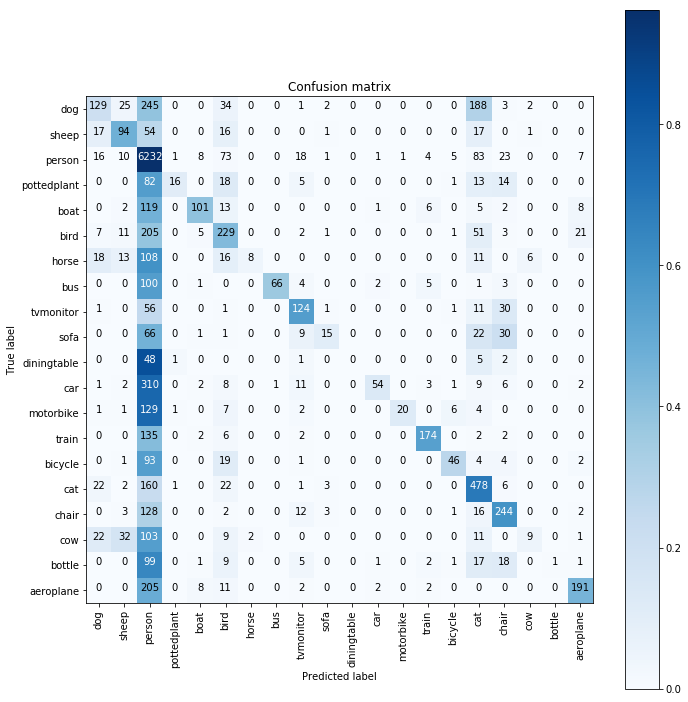

validation-top1
             precision    recall  f1-score   support

        dog       0.53      0.15      0.24       118
      sheep       0.51      0.44      0.47        41
     person       0.70      0.93      0.80      1118
pottedplant       0.50      0.06      0.11        34
       boat       0.57      0.22      0.32        36
       bird       0.36      0.38      0.37        85
      horse       0.50      0.04      0.07        28
        bus       1.00      0.31      0.47        26
  tvmonitor       0.38      0.38      0.38        37
       sofa       0.29      0.07      0.11        30
diningtable       0.00      0.00      0.00         9
        car       0.54      0.10      0.16        72
  motorbike       1.00      0.14      0.25        21
      train       0.88      0.49      0.63        59
    bicycle       0.69      0.31      0.43        29
        cat       0.36      0.65      0.46        95
      chair       0.40      0.48      0.44        61
        cow       0.50      0

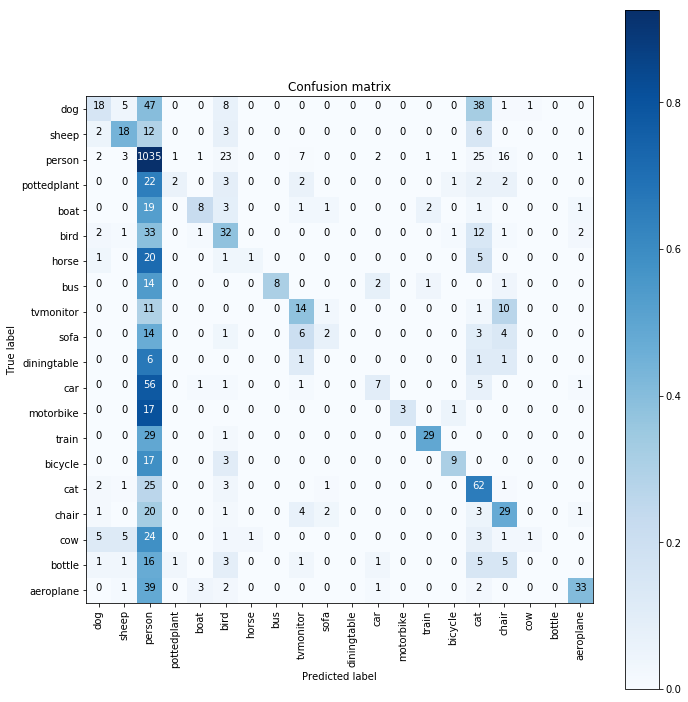

training-top2
             precision    recall  f1-score   support

        dog       0.57      0.67      0.62       679
      sheep       0.50      0.62      0.55       198
     person       0.80      0.99      0.88      6071
pottedplant       0.79      0.33      0.46       126
       boat       0.96      0.59      0.73       270
       bird       0.85      0.67      0.75       540
      horse       1.00      0.45      0.62       228
        bus       0.99      0.61      0.75       187
  tvmonitor       0.77      0.80      0.78       231
       sofa       0.74      0.51      0.60       148
diningtable       0.90      0.68      0.78        94
        car       1.00      0.61      0.76       476
  motorbike       0.99      0.45      0.62       198
      train       1.00      0.75      0.86       324
    bicycle       1.00      0.61      0.76       201
        cat       0.98      0.86      0.92       707
      chair       1.00      0.87      0.93       526
        cow       1.00      0.2

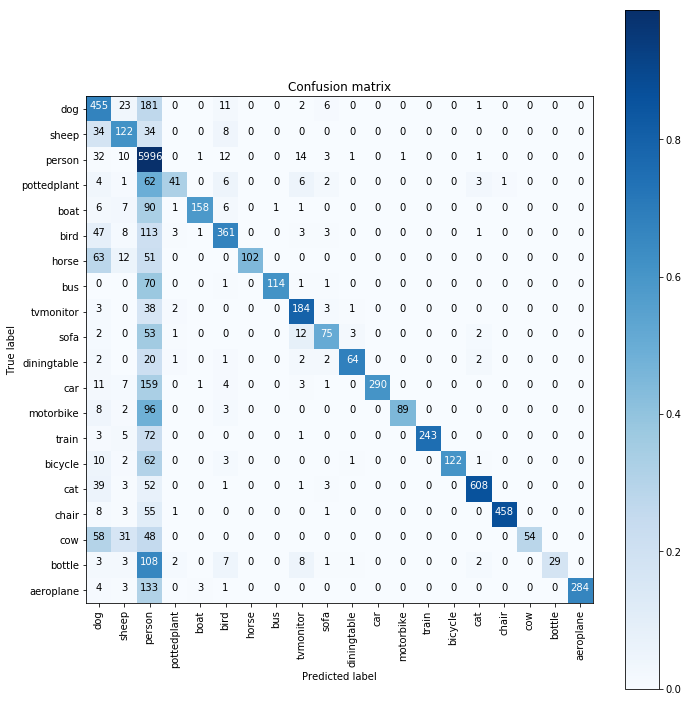

validation-top2
             precision    recall  f1-score   support

        dog       0.54      0.63      0.58       128
      sheep       0.53      0.64      0.58        42
     person       0.78      0.97      0.86      1068
pottedplant       0.67      0.17      0.28        23
       boat       0.84      0.47      0.60        34
       bird       0.79      0.62      0.70        87
      horse       0.93      0.40      0.56        35
        bus       1.00      0.65      0.79        26
  tvmonitor       0.64      0.62      0.63        40
       sofa       0.37      0.29      0.33        24
diningtable       0.71      0.67      0.69        15
        car       1.00      0.54      0.70        80
  motorbike       1.00      0.50      0.67        22
      train       1.00      0.77      0.87        57
    bicycle       1.00      0.64      0.78        33
        cat       0.93      0.81      0.87        95
      chair       1.00      0.73      0.84        88
        cow       1.00      0

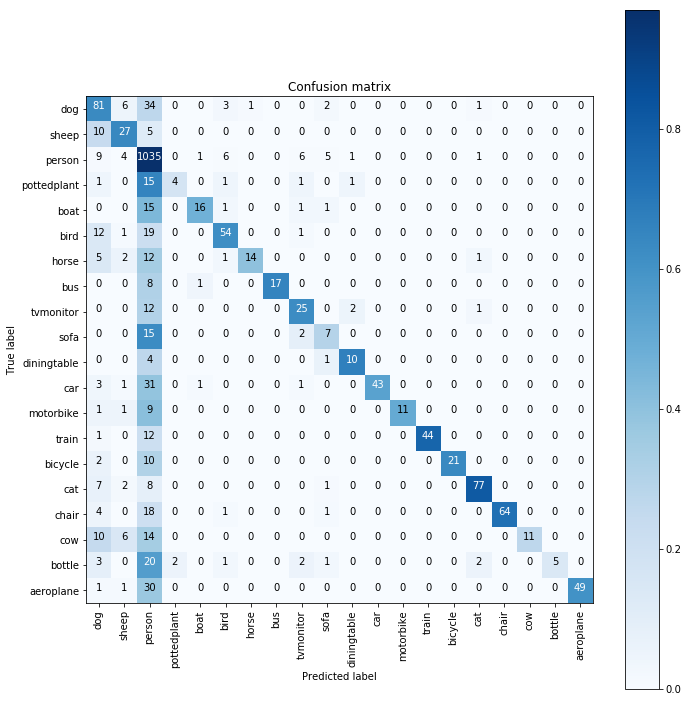

In [8]:
thres = np.zeros(20)
thres[2] = 1*0
print('training-top1')
predict_score = deepcopy(predict_score111-thres)
y_train2,predict_y2 = convert_label(y_train,predict_score,1)
modelAnalysis(y_train2, predict_y2,name_list,'cnn1.png')
print('validation-top1')
predict_score = deepcopy(predict_score113-thres)
y_val2,predict_y2 = convert_label(y_val,predict_score,1)
modelAnalysis(y_val2, predict_y2,name_list,'cnn12.png')

print('training-top2')
predict_score = deepcopy(predict_score111-thres)
y_train2,predict_y2 = convert_label(y_train,predict_score,2)
modelAnalysis(y_train2, predict_y2,name_list,'cnn3.png')
print('validation-top2')
predict_score = deepcopy(predict_score113-thres)
y_val2,predict_y2 = convert_label(y_val,predict_score,2)
modelAnalysis(y_val2, predict_y2,name_list,'cnn22.png')

testing-top1
             precision    recall  f1-score   support

        dog       0.48      0.17      0.26       184
      sheep       0.44      0.34      0.38        59
     person       0.70      0.94      0.81      1651
pottedplant       0.67      0.04      0.07        53
       boat       0.74      0.37      0.50        70
       bird       0.33      0.40      0.36       129
      horse       0.75      0.06      0.12        48
        bus       0.94      0.36      0.52        45
  tvmonitor       0.41      0.44      0.43        39
       sofa       0.62      0.16      0.26        31
diningtable       0.50      0.04      0.08        23
        car       0.81      0.14      0.24        94
  motorbike       0.75      0.09      0.15        35
      train       0.86      0.46      0.60        78
    bicycle       0.59      0.27      0.37        37
        cat       0.45      0.62      0.52       193
      chair       0.56      0.44      0.50       113
        cow       0.67      0.04

/home/cc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


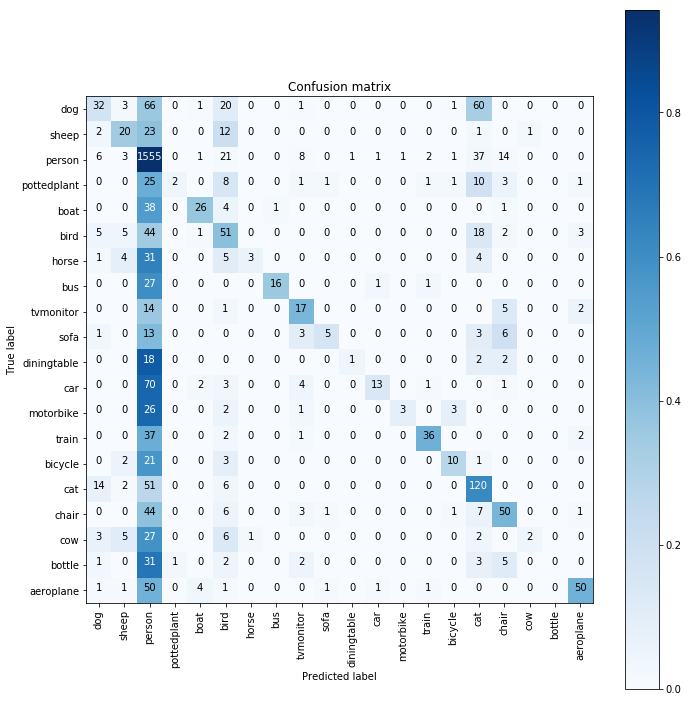

testing-top2
             precision    recall  f1-score   support

        dog       0.53      0.61      0.57       206
      sheep       0.48      0.57      0.52        56
     person       0.78      0.98      0.87      1563
pottedplant       0.67      0.17      0.28        46
       boat       0.96      0.65      0.77        68
       bird       0.76      0.61      0.68       129
      horse       1.00      0.36      0.53        56
        bus       1.00      0.49      0.66        51
  tvmonitor       0.63      0.79      0.70        43
       sofa       0.86      0.51      0.64        35
diningtable       0.81      0.49      0.61        35
        car       0.98      0.50      0.66       102
  motorbike       1.00      0.34      0.51        38
      train       1.00      0.74      0.85        76
    bicycle       1.00      0.60      0.75        48
        cat       0.96      0.78      0.86       197
      chair       1.00      0.76      0.86       132
        cow       1.00      0.17

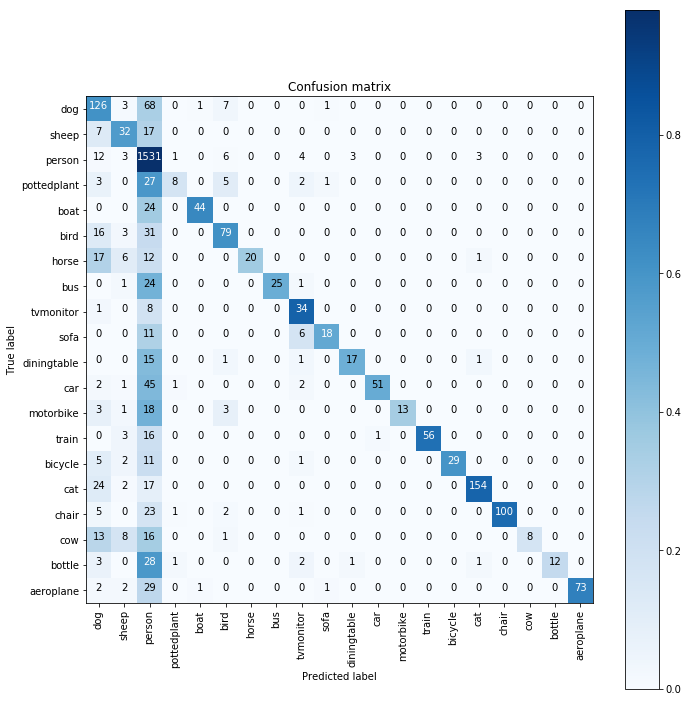

In [9]:
print('testing-top1')
predict_score = deepcopy(predict_score112-thres)
y_test2,predict_y2 = convert_label(y_test,predict_score,1)
modelAnalysis(y_test2, predict_y2,name_list,'cnn2.png')
print('testing-top2')
predict_score = deepcopy(predict_score112-thres)
y_test2,predict_y2 = convert_label(y_test,predict_score,2)
modelAnalysis(y_test2, predict_y2,name_list,'cnn4.png')